### 주요 라이브러리 모듈

- gensim: 다양한 텍스트 분석 기능을 제공하는 자연어 처리 패키지
  - gensim.corpora: 고빈도순 어휘 사전 생성
  - gensim.models: LDA/LSA 토픽 모델링
    - 단어의 토픽 가중치, 문서의 토픽 가중치, 토픽의 주요 단어 도출
  - gensim.corpora.CoherenceModel: 토픽 품질 평가


- pyLDAvis
  - 토픽 모델링 결과의 시각화

In [74]:
# 폴더구성
# dataset/0.nmh : 소스문서파일(전직대통령 연설문, json형태) , 
# dataset/topic_vis.html : 실험후 토픽모델링 시각화 결과파일 

In [75]:
!pip install konlpy #한국어 정보처리
!pip install pyLDAvis #토픽모델링의 LDA 모델의 학습결과를 시각적으로 표현하는 라이브러리

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
# Data Preprocessing Package
import re                       #정규식
import numpy as np
import pandas as pd
import os                      #디렉토리와 경로정보

# NLP Package
from konlpy.tag import * 
import gensim                    #토픽모델링을 하는 라이브러리
import gensim.corpora as corpora #텍스트분석
from gensim.models import CoherenceModel
from collections import Counter

# Visualization Package   #LDA시각화
import pyLDAvis 
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline


from pprint import pprint #pretty print
import itertools #iterable 객체 처리
import math

import logging #로그처리
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
 
import warnings #경고 무시
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [77]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Package Import & Parameter Setting

In [78]:
!pip install ujson
!pip install konlpy 
!pip install pyLDAvis 
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
# 기본 저장 주소
ROOT_PATH ="/content/gdrive/MyDrive/textmining/중간고사이후/dataset"

# 데이터 저장 주소
DATA_FOLDER_PATH = os.path.join(ROOT_PATH,"1.Data_my/")
DATA_FILE_NAME = os.path.join(DATA_FOLDER_PATH,"contents.xlsx")                  # Portal News Crawler에서 저장한 데이터 
DATA_STOP_WORD_FILE_NAME = os.path.join(DATA_FOLDER_PATH,"Data_stop_word.txt")   # 불용어 사전 

# 모델 저장 주소
MODEL_SAVE_FOLDER = os.path.join(ROOT_PATH,"2.Model_my/")
LDA_MODEL_SAVE_NAME = os.path.join(MODEL_SAVE_FOLDER, "Model_lda_topic_modeling.lda")
OPT_MODEL_SAVE_NAME = os.path.join(MODEL_SAVE_FOLDER, "Model_opt_topic_modeling.lda")

# 결과물 저장 주소
RESULT_FOLDER = os.path.join(ROOT_PATH,"3.Result_my/")
RESULT_SAVE_LDAVIS = os.path.join(RESULT_FOLDER,"Result_lda_vis.html")
RESULT_TOPIC_EXCEL = os.path.join(RESULT_FOLDER,"Result_topic_excel.xlsx")
RESULT_corpus_EXCEL = os.path.join(RESULT_FOLDER,"Result_corpus_excel.xlsx")

In [80]:
#import ujson #입력파일이 json형태
from gensim import corpora #gensim 에서 제공하는 패키지
from gensim import models
from gensim.models import CoherenceModel
from collections import Counter #카운터 사용



import pyLDAvis.gensim_models # LDA시각화

FEATURE_POSES = ["NNG", "NNP", "XR"] # NNG:일반명사, NNP:고유명사, XR:어근 
MA_KEY = "body_ma" #내용에 대한 부분은 bady_ma 키에 적혀져 있음
NUM_TOPICS = 20 #토픽의 개수
NUM_TOPIC_WORDS = 5 #하나의 토픽에 포함되는 단어수

INPUT_FILE = "/content/dataset/0.nmh" #입력파일
SAVE_HTML = "./dataset/0.nmh/topic_vis.html"    #시각화 결과파일

### 명사 추출한 형태소 분석기 별 실험



In [81]:
class textm():
    def __init__(self, text):
        self.text = text
    def split_sentences(self,sentence):  # 하나의 문서를 여러문장으로 나누기
        import re    
        all_sentences = []    
        lines = [line for line in sentence.strip().splitlines() if line.strip()]
        
        for line in lines:
            sentences = re.split("(?<=[.?!])\s+", line)
            all_sentences += sentences
        #self.sentences  = sentences
        return all_sentences
    def get_sentences(self):  #파일 불러오기

        sentences = []
        
        with open(self.text, "r", encoding="utf-8") as input_file:
            for sentence in input_file:
                sub_sentences = self.split_sentences(sentence)  # 호출
                sentences += sub_sentences
        self.sentences = sentences
        return self.sentences
      
    
    def get_parts(self,token):   #코로란 형태소 분석기 실행      
        from konlpy.tag import Kkma, Hannanum, Komoran, Mecab, Twitter, Okt
        okt = Okt()
        kkma1 = Kkma()
        hannanum = Hannanum()
        komoran1 = Komoran()
        token_list1 = [okt,kkma1,hannanum,komoran1]
        token1 = token_list1[token]
        results = []
        
        for sentence in self.sentences:
            parts = token1.pos(sentence) # get parts 에서 형태소 분석 진행
            for part in parts:
                results.append(part)
        self.results = results
        self.token_name = str(token1)
        return results
    def filtered_parts(self,num ): # 주요품사만 추출
        
        N_POS = ["NNG", "NNP","Noun","N"]  # NNG : 일반명사, NNP : 고유명사
        V_POS = ["VV", "VA",'Verb','P']    # "VV" : 동사, "VA" : 형용사
        X_POS = ["XR"]          # "XR" : 어근
        M_POS = ["MAG", "MAJ"]   # "MAG": 일반부사, "MAJ" : 접속부사
        filtered = [[],[],[],[]]
        
        for part in self.results:
            if part[1] in N_POS:
                filtered[0].append(part[0])
            elif part[1] in V_POS:
                filtered[1].append(part[0]) # 다가 필요한 경우
            elif part[1] in X_POS:
                filtered[2].append(part[0]+"하다") # 하다 가 필요한 경우
            elif part[1] in M_POS:
                filtered[3].append(part[0])
            else:
                continue 
        self.filtered = filtered[num]    
        return filtered[num]
    def word_count(self):    #빈도 체크하고 정렬
        from collections import Counter    
        wordform_counter = Counter()

        for word in self.filtered:
            wordform_counter[word] += 1    
      # most_common() 순서대로 보여줌
        print(self.token_name)
        for word, count in wordform_counter.most_common(10):  # most_common(10) 10개 추출
            print("{}: {}".format(word, count))    
        print('-----------------------------------------')

### 명사를 분류한 형태소 분석기 실험 (코드의 간소화를 위해 클래스로 만든 후 진행하였습니다.)

In [84]:
text1 = textm('/content/gdrive/MyDrive/textmining/중간고사이후/20182800나요셉.csv')
text1.get_sentences()
for i in range(4):
    text1.get_parts(i)
    text1.filtered_parts(0) #[N_pos,V_pos,X_pos,M_pos] 명사에 대해 형태소 분류기 별 차이 확인
    text1.word_count()

것: 1538
후보: 1341
이: 1061
고: 930
등: 860
수: 831
말: 648
우크라이나: 611
러시아: 543
그: 540
-----------------------------------------
후보: 1336
고: 935
러시아: 636
윤: 585
우: 569
국민: 558
전: 511
대선: 430
대통령: 413
김: 365
-----------------------------------------
것: 1703
후보: 1167
수: 1060
등: 857
이: 777
말: 567
전: 440
우크라: 375
그: 371
러시아: 351
-----------------------------------------
후보: 1339
말: 649
우크라이나: 601
러시아: 531
대선: 429
국민: 419
대통령: 394
사진: 358
윤: 315
힘: 295
-----------------------------------------


#### **TF-IDF 도출**

### 각 형태소 분류기 별 문서 단어 행렬 생성( 각 뉴스의 본문 마다 형태소 분류기 별 noun을 뽑고 딕셔너리에 저장)

In [ ]:
df = text1.get_sentences()

In [ ]:
from konlpy.tag import Kkma, Hannanum, Komoran,Okt 
kkma = Kkma()
kkma_dict = dict()
k = 0
for i in df:
  words = []
  for j in i:
    words.extend(kkma.nouns(str(j)))
  kkma_dict[k] = words
  k+=1 

In [ ]:
hannanum = Hannanum()
hannanum_dict = dict()
k = 0
for i in df:
  words = []
  for j in i:
    words.extend(hannanum.nouns(str(j)))
  hannanum_dict[k] = words
  k+=1 

In [ ]:
komoran1 = Komoran()
komoran_dict = dict()
k = 0
for i in df:
  words = []
  for j in i:
    words.extend(komoran1.nouns(str(j)))
  komoran_dict[k] = words
  k+=1 

In [ ]:
okt = Okt()
okt_dict = dict()
k = 0
for i in df:
  words = []
  for j in i:
    words.extend(okt.nouns(str(j)))
  okt_dict[k] = words
  k+=1 

#### 형태소 분류기 별 단어 사전 생성 후 DTM 행렬 생성

* 단어 사전 만들기

In [ ]:
from collections import Counter 
word_counts_kkma = []
vocabulary_kkma = set()
for key,value in kkma_dict.items():
  vocabulary_kkma.update(value)
  word_count = Counter(value)
  word_counts_kkma.append(word_count) 
doc_dict_list_kkma = []

for word_count in word_counts_kkma:
    term_vec = {}
    for voca in vocabulary_kkma:
        term_vec[voca] = word_count.get(voca, 0)     
    doc_dict_list_kkma.append(term_vec)

In [ ]:
word_counts_hannanum = []
vocabulary_hannanum = set()
for key,value in hannanum_dict.items():
  vocabulary_hannanum.update(value)
  word_count = Counter(value)
  word_counts_hannanum.append(word_count) 
doc_dict_list_hannanum = []

for word_count in word_counts_hannanum:
    term_vec = {}
    for voca in vocabulary_hannanum:
        term_vec[voca] = word_count.get(voca, 0)     
    doc_dict_list_hannanum.append(term_vec)

In [ ]:
word_counts_komoran = []
vocabulary_komoran = set()
for key,value in komoran_dict.items():
  vocabulary_komoran.update(value)
  word_count = Counter(value)
  word_counts_komoran.append(word_count) 
doc_dict_list_komoran = []

for word_count in word_counts_komoran:
    term_vec = {}
    for voca in vocabulary_komoran:
        term_vec[voca] = word_count.get(voca, 0)     
    doc_dict_list_komoran.append(term_vec)

In [ ]:
word_counts_okt = []
vocabulary_okt = set()
for key,value in okt_dict.items():
  vocabulary_okt.update(value)
  word_count = Counter(value)
  word_counts_okt.append(word_count) 
doc_dict_list_okt = []

for word_count in word_counts_okt:
    term_vec = {}
    for voca in vocabulary_okt:
        term_vec[voca] = word_count.get(voca, 0)     
    doc_dict_list_okt.append(term_vec)

* 빈도 행렬 생성

In [ ]:
doc_vec_list_kkma = []
doc_vec_list_okt = []
doc_vec_list_hannanum = []
doc_vec_list_komoran = []
for word_count in word_counts_kkma:
    term_vec = []
    for voca in vocabulary_kkma:
        term_freq = word_count.get(voca, 0)
        term_vec.append(term_freq)
    doc_vec_list_kkma.append(term_vec)
doc_term_mat_kkma = np.array(doc_vec_list_kkma)   
for word_count in word_counts_okt:
    term_vec = []
    for voca in vocabulary_okt:
        term_freq = word_count.get(voca, 0)
        term_vec.append(term_freq)
    doc_vec_list_okt.append(term_vec)
doc_term_mat_okt = np.array(doc_vec_list_okt)   
for word_count in word_counts_hannanum:
    term_vec = []
    for voca in vocabulary_hannanum:
        term_freq = word_count.get(voca, 0)
        term_vec.append(term_freq)
    doc_vec_list_hannanum.append(term_vec)
doc_term_mat_hannanum = np.array(doc_vec_list_hannanum)   
for word_count in word_counts_komoran:
    term_vec = []
    for voca in vocabulary_komoran:
        term_freq = word_count.get(voca, 0)
        term_vec.append(term_freq)
    doc_vec_list_komoran.append(term_vec)
doc_term_mat_komoran = np.array(doc_vec_list_komoran)   

In [ ]:
doc_term_mat_kkma.shape,doc_term_mat_okt.shape,doc_term_mat_hannanum.shape,doc_term_mat_komoran.shape

### 사이킷런을 통한 각 형태소 분류기 별 TF-IDF 행렬 생성

In [ ]:
kkma_word = list(kkma_dict.values())
kkma_words = []
for i in kkma_word:
  kkma_words.append(' '.join(i))
komoran_word = list(komoran_dict.values())
komoran_words = []
for i in komoran_word:
  komoran_words.append(' '.join(i))
okt_word = list(okt_dict.values())
okt_words = []
for i in okt_word:
  okt_words.append(' '.join(i))
hannanum_word = list(hannanum_dict.values())
hannanum_words = []
for i in hannanum_word:
  hannanum_words.append(' '.join(i))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer   

vectorizer = CountVectorizer(tokenizer=str.split)       
#vectorizer = CountVectorizer() 

doc_term_mat_kkma1 = vectorizer.fit_transform(kkma_words)   # 각 형태소 분류기 별 문서별 단어 나열한 것을 학습
doc_term_mat_d_kkma1 = doc_term_mat_kkma1.toarray()                                                           
vocabulary_kkma = vectorizer.vocabulary_    
                                                                     
vectorizer1 = CountVectorizer(tokenizer=str.split)   
doc_term_mat_hannanum1 = vectorizer1.fit_transform(hannanum_words)  
doc_term_mat_d_hannanum1 = doc_term_mat_hannanum1.toarray()                                                          
vocabulary_hannanum = vectorizer1.vocabulary_

vectorizer2 = CountVectorizer(tokenizer=str.split)   
doc_term_mat_komoran1 = vectorizer2.fit_transform(komoran_words)  
doc_term_mat_d_komoran1 = doc_term_mat_komoran1.toarray()                                                          
vocabulary_komoran = vectorizer2.vocabulary_

vectorizer3 = CountVectorizer(tokenizer=str.split)   
doc_term_mat_okt1 = vectorizer3.fit_transform(okt_words)  
doc_term_mat_d_okt1 = doc_term_mat_okt1.toarray()                                                          
vocabulary_okt = vectorizer3.vocabulary_


* 각 분류기 별 단어 사전을 통해 TF-IDF 행렬 생성 후 단어 별 TF-IDF 최대 값 확인

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = None)             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(okt_words)
doc_term_mat_d1 = doc_term_mat.toarray()


print(doc_term_mat_d1.shape) 

plt.plot(doc_term_mat_d1.max(axis= 0),label = 'OKT')
vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = None)             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(kkma_words)
doc_term_mat_d2 = doc_term_mat.toarray()
print(doc_term_mat_d2.shape)
plt.plot(doc_term_mat_d2.max(axis= 0),label = 'KKma')

vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = None)             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(hannanum_words)
doc_term_mat_d3 = doc_term_mat.toarray()
print(doc_term_mat_d3.shape)
plt.plot(doc_term_mat_d3.max(axis= 0),label = 'Hannanum')

vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = None)             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(komoran_words)
doc_term_mat_d4 = doc_term_mat.toarray()
print(doc_term_mat_d4.shape)
plt.plot(doc_term_mat_d4.max(axis= 0),label = 'Komoran')
plt.legend()

* 각 문서 별 TF-IDF 편차 확인

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = None)             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(okt_words)
doc_term_mat_d1 = doc_term_mat.toarray()


print(doc_term_mat_d1.shape) 

plt.plot(doc_term_mat_d1.std(axis= 1),label = 'OKT')
vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = None)             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(kkma_words)
doc_term_mat_d2 = doc_term_mat.toarray()
print(doc_term_mat_d2.shape)
plt.plot(doc_term_mat_d2.std(axis= 1),label = 'KKma')

vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = None)             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(hannanum_words)
doc_term_mat_d3 = doc_term_mat.toarray()
print(doc_term_mat_d3.shape)
plt.plot(doc_term_mat_d3.std(axis= 1),label = 'Hannanum')

vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = None)             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(komoran_words)
doc_term_mat_d4 = doc_term_mat.toarray()
print(doc_term_mat_d4.shape)
plt.plot(doc_term_mat_d4.std(axis= 1),label = 'Komoran')
plt.legend()

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = 'l2')             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(okt_words)
doc_term_mat_d5 = doc_term_mat.toarray()


print(doc_term_mat_d5.shape) 

plt.plot(doc_term_mat_d5.max(axis= 0),label = 'OKT')
vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = 'l2')             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(kkma_words)
doc_term_mat_d6 = doc_term_mat.toarray()
print(doc_term_mat_d6.shape)
plt.plot(doc_term_mat_d6.max(axis= 0),label = 'KKma')

vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = 'l2')             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(hannanum_words)
doc_term_mat_d7 = doc_term_mat.toarray()
print(doc_term_mat_d7.shape)
plt.plot(doc_term_mat_d7.max(axis= 0),label = 'Hannanum')

vectorizer = TfidfVectorizer(tokenizer=str.split,  norm = 'l2')             # 정규화하지 않음. norm 생략시 L2 정규화
doc_term_mat = vectorizer.fit_transform(komoran_words)
doc_term_mat_d8 = doc_term_mat.toarray()
print(doc_term_mat_d8.shape)
plt.plot(doc_term_mat_d8.max(axis= 0),label = 'Komoran')
plt.legend()

### 필요 함수 정의

In [85]:
#import kss
from konlpy.tag import Komoran
import re
class textm():
    def __init__(self, text):
        self.text = text
    def split_sentences(self,sentence):  # 하나의 문서를 여러문장으로 나누기
        import re    
        all_sentences = []    
        lines = [line for line in sentence.strip().splitlines() if line.strip()]
        lines = [line for line in lines if len(line) != 0 ]
        
        for line in lines:
            sentences = re.split(r"(?<=[.?!]\/)\s+", line)
            all_sentences += sentences
        return all_sentences
    def get_sentences(self):  #파일 불러오기
        input_file = pd.read_csv(self.text)

        sentences = []
        for sentence in input_file['기사내용']:
            sub_sentences = self.split_sentences(sentence)  # 호출
            sentences+=sub_sentences
        self.sentences = sentences
        return self.sentences
    def get_doc(self):  #파일 불러오기
          input_file = pd.read_csv(self.text)

          sentences = []
          input_file = input_file.drop_duplicates()
          for sentence in input_file['기사내용']:
              sub_sentences = self.split_sentences(sentence)  # 호출
              sentences.append(sub_sentences)
          self.sentences = sentences
          return self.sentences

In [86]:
text1 = textm('/content/gdrive/MyDrive/textmining/중간고사이후/20182800나요셉.csv')

In [87]:
raw = pd.read_csv('/content/gdrive/MyDrive/textmining/중간고사이후/20182800나요셉.csv')

### TF-IDF  행렬을 통한 문서 별 영향력 높은 단어 비교

In [88]:
text1.get_doc()[1]

['[경향신문]',
 '백신 미접종자 카페·식당 제약 없이 이용',
 '음성확인서, 동네 지정 병원서 유료 발급',
 '종교시설 299명 제한 규정 13일까지 유지',
 '경향신문 자료사진. 이준헌 기자',
 '1일부터 전국에서 방역패스(백신 접종증명·음성확인제)가 사라지면서 네이버·카카오 등 포털·모바일메신저 애플리케이션이 제공한 QR코드 인증 기능도 멈췄다. 전국 보건소와 선별진료소도 방역패스로 쓰였던 음성확인서 발급을 중단했다. 또 확진자 가족의 자가격리 의무도 백신 접종 여부와 상관없이 없어지면서 ‘수동감시’로 바뀌었다. 이날부터 바뀐 방역정책 세부사항을 문답 형식으로 풀어봤다.',
 '-미접종자가 식당·카페 갈 때 달라진 점은.',
 '“방역패스가 적용될 때는 일행 없이 혼자서만 취식을 해야 했다. 일행과 함께 하려면 PCR(유전자 증폭)·신속항원검사 음성확인서나 완치증명서가 필요했는데, 이제는 그런 조건들이 모두 사라졌다. 미접종자도 일행과 함께 자유롭게 식당·카페를 이용할 수 있다.”',
 '-일부 기업이 회의 등에 사실상 방역패스를 운영했는데.',
 '“정부는 음성확인서 발급을 임의로 요청하는 기업·기관에게 자제를 당부하고 있다. 이제 보건소·선별진료소가 더 이상 음성확인서를 발급하지 않기 때문이다. 다만 동네 병원(호흡기전담클리닉, 호흡기 진료 지정 의료기관)에서 유료로 음성확인서를 받을 수 있다.”',
 '-교회 예배에 299명까지만 참석할 수 있는 규정은.',
 '“유지된다. 교회·사찰 등 종교시설에서는 미접종자가 참여하면 수용인원의 30%까지, 접종완료자만 참여시 70%까지 가능하다는 방역패스 규정만 사라진다. 299명 제한은 사회적 거리두기에 따른 규정이므로 13일까지 계속 적용된다.”',
 '-수동감시란 무엇인가.',
 '“스스로 건강 상태를 관찰하면서 방역수칙을 준수하는 것을 말한다. 확진자 동거인은 3일째 PCR 검사, 6~7일째 신속항원검사를 권고받는다. 확진자 검사일을 ‘1일째’로 삼으면 된다. 신속항원검사는 자가검사키트를 써도

In [89]:
stopword_vocab = DATA_STOP_WORD_FILE_NAME 

#globals()['stopword_vocab'] = []
    
#return [[word for word in doc if word not in globals()['stopword_vocab']] for doc in globals()['list_sent2words']]

In [90]:
komoran1 = Komoran()
FEATURE_POSES = ["NNG", "NNP", "XR"]
doc = []
for i in text1.get_doc():
  mini_doc = []
  for j in i :
    parts = komoran1.pos(j)
    for part in parts:
      if part[1] in FEATURE_POSES:
        mini_doc.append(part[0])
  doc.append(mini_doc)

In [91]:
w2v_doc = []
for i in doc:
  w2v_doc += i 

In [92]:
doc_str = []
for i in range(len(doc)):
  doc_str.append(' '.join(doc[i]))

In [93]:
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer  

In [94]:
vectorizer = TfidfVectorizer(tokenizer=str.split, norm = "l2")      #norm = "l2"  를 생략해도 동일
doc_term_mat = vectorizer.fit_transform(doc_str)
doc_term_mat_d = doc_term_mat.toarray()

print(vectorizer.get_feature_names())
print(doc_term_mat_d)

['-0', '-1', '-2', '-3', '.co', '.com', '.do', '.gl', '.kr', '.ly', '.moe', '0시', '1.5', '10', '100%', '100년', '100분', '101', '101마리', '10년', '10대', '10분', '10억', '10월', '10일', '11', '114', '119', '11년', '11월', '11일', '12년', '12월', '12일', '13', '13일', '14', '14일', '15년', '15일', '16년', '16일', '17일', '180', '18일', '19', '1930년대', '1941년', '1960년대', '1969년', '1980년', '1980년대', '1990년대', '1998년', '19대', '19세기', '19일', '1년', '1시', '1월', '1인', '1일', '2', '2000년대', '2001년', '2002년', '2007년', '2008년', '2010년', '2010년대', '2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년', '2026년', '2027년', '2030년', '2030년대', '2055년', '20년', '20대', '20일', '21', '21년', '21세기', '21일', '22', '23일', '24', '24일', '25', '25년', '25일', '26년', '27', '27일', '28', '28일', '29일', '2년', '2시', '2월', '2일', '2차', '30년', '30대', '30일', '31일', '3b', '3d', '3t', '3·1', '3·1절', '3국', '3년', '3당', '3분', '3불', '3월', '3인조', '3일', '3차원', '4', '40', '45', '4x', '4년', '4월', '5년', '5월', '5일', '6

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [95]:
freq_list = []
for i in range(doc_term_mat_d.shape[0]): 
    print(f'{i}번째 문서의 중요 단어 :', vectorizer.get_feature_names()[doc_term_mat_d[i].argmax()])
    freq_list.append(vectorizer.get_feature_names()[doc_term_mat_d[i].argmax()])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0번째 문서의 중요 단어 : 귤
1번째 문서의 중요 단어 : 방역
2번째 문서의 중요 단어 : 평화
3번째 문서의 중요 단어 : 후보
4번째 문서의 중요 단어 : 폭탄
5번째 문서의 중요 단어 : 마비
6번째 문서의 중요 단어 : 삼겹살
7번째 문서의 중요 단어 : 우크라이나
8번째 문서의 중요 단어 : 러시아
9번째 문서의 중요 단어 : 렌스
10번째 문서의 중요 단어 : 광고
11번째 문서의 중요 단어 : 넷플릭스
12번째 문서의 중요 단어 : 롤
13번째 문서의 중요 단어 : 이사
14번째 문서의 중요 단어 : 체첸
15번째 문서의 중요 단어 : 이광
16번째 문서의 중요 단어 : 아들
17번째 문서의 중요 단어 : 후보
18번째 문서의 중요 단어 : 표식
19번째 문서의 중요 단어 : 자산
20번째 문서의 중요 단어 : 이사장
21번째 문서의 중요 단어 : 스위스
22번째 문서의 중요 단어 : 책
23번째 문서의 중요 단어 : 후보
24번째 문서의 중요 단어 : 투표
25번째 문서의 중요 단어 : 후보
26번째 문서의 중요 단어 : 용지
27번째 문서의 중요 단어 : 후보
28번째 문서의 중요 단어 : 피오
29번째 문서의 중요 단어 : 후보
30번째 문서의 중요 단어 : 입대
31번째 문서의 중요 단어 : 시험
32번째 문서의 중요 단어 : 투표
33번째 문서의 중요 단어 : 선언문
34번째 문서의 중요 단어 : 후보
35번째 문서의 중요 단어 : 약점
36번째 문서의 중요 단어 : 푸틴
37번째 문서의 중요 단어 : 관장
38번째 문서의 중요 단어 : 후보
39번째 문서의 중요 단어 : 휴먼
40번째 문서의 중요 단어 : 투명
41번째 문서의 중요 단어 : 단속
42번째 문서의 중요 단어 : 청약
43번째 문서의 중요 단어 : 데이터
44번째 문서의 중요 단어 : 전쟁범죄
45번째 문서의 중요 단어 : 오리온
46번째 문서의 중요 단어 : 투표
47번째 문서의 중요 단어 : 원전
48번째 문서의 중요 단어 : 러시아
49번째 문서의 중요 단어 : 호

In [96]:
dictionary = corpora.Dictionary(doc)
dictionary
corpus = [dictionary.doc2bow(document) for document in doc]

In [97]:
tfidf_word = [ ]
for i in range(pd.DataFrame(doc_term_mat_d.T).shape[1]):
  tfidf_word += list(pd.DataFrame(doc_term_mat_d.T)[i].sort_values().tail(10).index)

In [98]:
tfidf_word_dict = dict()
for i in tfidf_word:
  tfidf_word_dict[vectorizer.get_feature_names()[i]] = tfidf_word.count(i)
tfidf_word_dict # TF-IDF 에서 각 문서당 상위 10개의 단어를 추출한 것.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'글': 6,
 '오렌지': 1,
 '계정': 1,
 '게시': 2,
 '사진': 3,
 '트위터': 3,
 '우크라이나': 46,
 '후보': 65,
 '삭제': 2,
 '귤': 1,
 '패스': 6,
 '확진': 19,
 '규정': 1,
 '접종': 9,
 '확인서': 1,
 '검사': 7,
 '음성': 3,
 '미접': 1,
 '종자': 1,
 '방역': 10,
 '세계': 2,
 '침략': 1,
 '시민': 1,
 '인류': 1,
 '심': 4,
 '전쟁': 6,
 '인권': 3,
 '대한민국': 1,
 '평화': 4,
 '고창': 1,
 '대통령': 19,
 '전북': 3,
 '민주주의': 2,
 '김대중': 1,
 '기호': 1,
 '완주': 2,
 '도덕': 1,
 '유세': 9,
 '무기': 3,
 '협약': 1,
 '러시아': 41,
 '사용': 1,
 '전쟁범죄': 2,
 '집속탄': 1,
 '진공': 1,
 '폭탄': 1,
 '호전': 1,
 '증상': 3,
 '교통사고': 1,
 '선고': 2,
 '혐의': 4,
 '행세': 1,
 '모녀': 1,
 '보험금': 3,
 '전신': 1,
 '마비': 1,
 '카드': 5,
 '판매': 4,
 '목심': 1,
 '행사': 1,
 '데이': 1,
 '매시': 1,
 '냉동': 1,
 '이마트': 1,
 '할인': 3,
 '삼겹살': 2,
 '정치': 6,
 '비판': 1,
 '영상': 7,
 '기부': 2,
 '올레': 1,
 '모델': 3,
 '출신': 1,
 '레나': 1,
 '군수': 1,
 '기름': 1,
 '전술': 1,
 '물자': 1,
 '파괴': 1,
 '탱크': 1,
 '장갑차': 2,
 '러시아군': 9,
 '로디': 1,
 '미르': 1,
 '더': 1,
 '타임즈': 1,
 '용병': 2,
 '젤': 5,
 '렌스': 5,
 '인권위': 1,
 '승인': 1,
 '공': 1,
 '심의': 1,
 '대위': 3,
 '변희': 1,
 '공사': 3,
 '하사': 1,
 '교통

In [99]:
word_cloud_list = []
for i in tfidf_word:
  word_cloud_list.append(vectorizer.get_feature_names()[i])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [100]:
tfidf_word1 = []
for i in range(pd.DataFrame(doc_term_mat_d.T).shape[1]):
  tfidf_word1.append(list(pd.DataFrame(doc_term_mat_d.T)[i].sort_values().tail(10).index))
w2v_list = []
for i in tfidf_word1:
  mini = []
  for j in i:
    mini.append(vectorizer.get_feature_names()[j])
  w2v_list.append(mini)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [101]:
word_cloud_list = " ".join(word_cloud_list)

In [102]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [103]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [104]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#/content/drive/MyDrive/textmining/6week/그림1.jpg

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',family='Malgun Gothic')

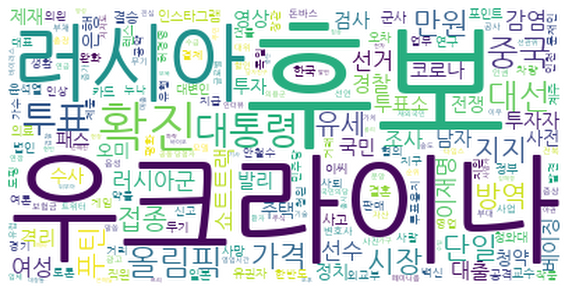

In [106]:
#text=open("text.txt").read()
from wordcloud import STOPWORDS
FONTPATH='NanumGothic.ttf'
stopwords=set(STOPWORDS)
wordcloud=WordCloud( font_path=FONTPATH,max_font_size=100, max_words=200,stopwords = stopwords,background_color="white")
#wordcloud=WordCloud(max_font_size=100, max_words=200, background_color="white",random_state=10,stopwords=stopwords, mask=img_mask, color_func=image_colors, font_path=FONTPATH)
wc=wordcloud.generate(word_cloud_list) #text 의 빈도를 보고 워드 클라우드를 생성한 것이다.
plt.figure(figsize=(10,10))
plt.imshow(wc,interpolation="lanczos") # interpolation 은 이미지를 부드럽게 나타내는 정도이다.
plt.axis("off")
plt.show() # TF-IDF 주요 단어로 본 워드 클라우드

### 워드투벡터

In [27]:
import ujson
import gensim
from gensim.models import Word2Vec

def main():
    
    sentences = doc
# Word2Vec------------------------------------------------------------------------
    model = Word2Vec(sentences, size=100, window=5, min_count=5) # Word2Vec
# -------------------------------------------------------------------------   
    utilize(model)


def utilize(model):
    
    word_vectors = model.wv
    
    print(word_vectors.vocab.keys()) # 단어리스트

    print(word_vectors.index2word[:]) # 빈도순의 단어리스트
    
    print(word_vectors["미국"]) # 미국이라는 단어의 100차원의 실제 벡터값
    
    print(word_vectors.similarity("러시아", "중국")) # 러시아와 중국의 유사도
    
    print(word_vectors.n_similarity(["러시아", "중국"], ["미국", "일본"]))
    print(word_vectors.similar_by_word("일본", topn = 5)) # 일본과 유사한 단어 5개, topn의 기본값은10
    
    print(word_vectors.most_similar(positive=["대한민국"], negative=["미국"], topn=5))
    
    print(word_vectors.most_similar(positive=["대한민국", "중국"], negative=["일본"]))
    

def save_reuse(model):


main()

dict_keys(['경향신문', '우크라이나', '글', '얼굴', '귤', '사진', '게재', '누리꾼', '지적', '삭제', '윤석열', '국민', '힘', '대선', '후보', '사회관계', '망', '서비스', '트위터', '발언', '윤', '오전', '공식', '계정', '귀', '모양', '해당', '게시', '시간', '이상', '공유', '일부', '러시아', '침공', '사태', '호주', '방송', '소속', '기자', '한국', '경선', '선두', '보수', '정당', '이러', '수고', '언급', '외신', '눈치', '전', '반려', '동물', '전쟁', '비판', '배경', '응원', '의미', '확인', '정치', '오해', '소지', '부정', '선거', '규탄', '시위', '뜻', '지난해', '10월', '대통령', '사과', '직후', '인스타그램', '견', '앞', '일명', '여론', '백신', '미접', '종자', '카페', '식당', '제약', '이용', '음성', '확인서', '동네', '지정', '병원', '발급', '시설', '제한', '규정', '유지', '자료', '헌', '전국', '방역', '패스', '접종', '증명', '네이버', '카카오', '모바일', '제공', '코드', '인증', '기능', '보건소', '선별', '진료소', '중단', '확진', '가족', '자가', '격리', '의무', '여부', '수동', '감시', '이날', '정책', '사항', '때', '적용', '일행', '혼자', '유전자', '증폭', '신속', '항원', '검사', '완치', '필요', '이제', '조건', '자유', '기업', '회의', '사실', '운영', '정부', '임의', '요청', '기관', '자제', '당부', '호흡기', '전담', '진료', '의료', '참석', '사찰', '참여', '수용', '인원', '완료', '가능', '사회', '거리', '두기', '건강', '상태', '관찰

In [107]:
model = Word2Vec(doc, size=100, window=5, min_count=5) 
mdoel_tfidf = Word2Vec(w2v_list,size = 100 , window = 5 , min_count = 5)

In [46]:
len(model.wv.vocab)
print('코로나:',model.wv.similar_by_word("코로나", topn = 5))
print('러시아:',model.wv.similar_by_word("러시아", topn = 5))
print('후보:',model.wv.similar_by_word("후보", topn = 5))

코로나: [('확진', 0.99165940284729), ('19', 0.9905292987823486), ('신규', 0.9866063594818115), ('감염증', 0.9857984781265259), ('감염', 0.9838491678237915)]
러시아: [('우크라이나', 0.9997795820236206), ('침공', 0.9997663497924805), ('현지', 0.9988715648651123), ('반군', 0.9984369277954102), ('개시', 0.9980727434158325)]
후보: [('대선', 0.9990048408508301), ('윤석열', 0.9986903667449951), ('힘', 0.9981350898742676), ('더불어민주당', 0.9959319829940796), ('국민', 0.9899953603744507)]


In [108]:
print('코로나:',model_tfidf.wv.similar_by_word("코로나", topn = 5))
print('러시아:',model_tfidf.wv.similar_by_word("러시아", topn = 5))
print('후보:',model_tfidf.wv.similar_by_word("후보", topn = 5))

코로나: [('공격', 0.2598044276237488), ('가격', 0.18589724600315094), ('황', 0.1802297830581665), ('격리', 0.16030804812908173), ('사망', 0.1554010808467865)]
러시아: [('젤', 0.20361271500587463), ('사전', 0.18267640471458435), ('경찰', 0.1470489501953125), ('표', 0.14614337682724), ('방역', 0.11631479859352112)]
후보: [('김', 0.2659268081188202), ('유세', 0.1967998594045639), ('발리', 0.19024240970611572), ('푸틴', 0.18345075845718384), ('패스', 0.18272022902965546)]


### Topic Modeling

#### 말뭉치 및 사전 생성

In [48]:
 # 입력파일로부터 읽어들어 문서를 반환


# documents을 받아서 문서 단어 행렬 만듬
def build_doc_term_mat(documents): 
    
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    return corpus, dictionary

# term을 입력. 단어를 입력하면(예,정치), 단어가 여러 토픽에 해당될 수 있는데 각 토픽에서 갖는 가중치를 표시
def print_term_topics(term, dictionary, model):
    word_id = dictionary.token2id[term]   #단어의 아이디 구함
    print(model.get_term_topics(word_id))  

# 문서에 대한 토픽가중치를 반복하면서 전체 문서에 대해서 표시
def print_doc_topics(model, corpus): 
    
    for doc_num, doc in enumerate(corpus):
        topic_probs = model[doc]
        print("Doc num: {}".format(doc_num))

        for topic_id, prob in topic_probs:
            print("\t{}\t{}".format(topic_id, prob))
        
        if doc_num == 2:  # 시간 관계상 2번 문서까지만 출력, "0번문서, 1번문서, 2번문서"에 대해서만 해당문서의 토픽가중치를 표시                                     
            break

        print("\n")  

# ★ 모델링 후 각 토픽별로 중요한 단어들을 표시
def print_topic_words(model):
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))

        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))
        print("\n")

In [49]:
#documents = read_documents(INPUT_FILE) #입력파일을 문서형태로 생성
corpus, dictionary = build_doc_term_mat(doc) #문서단위 행열 만들어서 말뭉치와 사전을 생성,여기서 doc 은 350개 문서로 나뉘어져 ㅇㅆ다. 
# corpus 의 경우 Dictionary 가 생긴 후 각 단어가 얼마나 나왔는지 문서별로 출력해준다.
print(dictionary.token2id)                  
print(corpus[2][:5])    # 각 문서별 (용어ID, 빈도) 생성  --> 2번 문서의 첫 다섯 용어의 ID와 빈도 출력, 780개의 문서
# coupus : 각문서에 대해서 단어를 담고 있는것, 단어 아이디와 빈도를 같이 가지고 있음                                        
#copus[2][:5] : 2번문서에 대해서 첫 5개 단어(0,1,2,3,4)까지 표시
# 결과 해석 [(6, 1), (9, 3), (14, 1), (15, 2), (19, 1)]
# => 6번단어가 1번 나옴, 9번단어가 3번, 14번 용어가 1번, 15번 용어가 2번, 19번 용어가 1번 나옴

{'10월': 0, '게시': 1, '게재': 2, '견': 3, '경선': 4, '경향신문': 5, '계정': 6, '공식': 7, '공영': 8, '공유': 9, '국민': 10, '귀': 11, '귀여움': 12, '규탄': 13, '귤': 14, '글': 15, '글귀': 16, '기이': 17, '기자': 18, '껍질': 19, '누리꾼': 20, '눈치': 21, '당혹': 22, '대선': 23, '대통령': 24, '동물': 25, '뜻': 26, '라': 27, '라파엘': 28, '러시아': 29, '만화': 30, '망': 31, '모양': 32, '뭇매': 33, '반려': 34, '발언': 35, '방송': 36, '배경': 37, '보수': 38, '부정': 39, '비판': 40, '사과': 41, '사진': 42, '사태': 43, '사회관계': 44, '삭제': 45, '서비스': 46, '선거': 47, '선두': 48, '소속': 49, '소지': 50, '수고': 51, '시간': 52, '시드': 53, '시위': 54, '실무자': 55, '앞': 56, '언급': 57, '얼굴': 58, '여론': 59, '오렌지 혁명': 60, '오전': 61, '오해': 62, '옹호': 63, '외신': 64, '우크라이나': 65, '윤': 66, '윤석열': 67, '응원': 68, '의미': 69, '이러': 70, '이상': 71, '인스타그램': 72, '일명': 73, '일부': 74, '장난': 75, '전': 76, '전두환': 77, '전쟁': 78, '정당': 79, '정치': 80, '지난해': 81, '지적': 82, '직후': 83, '침공': 84, '캐릭터': 85, '캡': 86, '트위터': 87, '프리랜서': 88, '한국': 89, '해당': 90, '호주': 91, '확인': 92, '후보': 93, '힘': 94, '가능': 95, '가족': 96, '감시': 97, '감염': 98, '개

In [50]:
# Perplexity와 Coherence Score 을 판단
#print('토픽 기본 모델링을 실시 합니다. 해당 모델은 "lda_model" 변수로 입력됩니다.')
#print(' ')

#NUM_TOPICS = int(input('토픽의 개수를 입력해 주세요. '))
#TOPICS_W_NUM = int(input('출력할 토픽별 단어의 개수를 입력해 주세요 '))
#save_lda_model= int(input("선택한 토픽 모델을 저장하시겠습니까? \n0 저장  \n1 미저장  "))

TOPICS_W_NUM =20
save_lda_model=0
RANDOM_STATE = 100
UPDATE_EVERY = 1
CHUNKSIZE = 100
PASSES = 10
ALPHA = 'auto'
PER_WORD_TOPICS = True
print('NUM_TOPICS', 'perplexity', 'coherence')
for i in range(1,20):
  NUM_TOPICS=i
 
  #해당 셀은 토픽모델링(LDA)에 대해 모델을 정의하는 셀입니다.
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                                              num_topics=NUM_TOPICS, random_state=RANDOM_STATE, 
                                              update_every=UPDATE_EVERY, chunksize=CHUNKSIZE,
                                             passes=PASSES, alpha=ALPHA, per_word_topics=PER_WORD_TOPICS)

  # 토픽 출력
 #  pprint(lda_model.print_topics(num_words=TOPICS_W_NUM))
  doc_lda = lda_model[corpus]

  # 모델 저장 
  if save_lda_model == 0:
      lda_model.save(LDA_MODEL_SAVE_NAME)
  # 0번 토픽,- 중요단어들이 가중치 순으로 나옴(20개)
  """
  해당 셀은 설계한 모델을 계산하는 셀입니다.
  측정은 Perplexity와 Coherence Score입니다.
  """
  #print('\nNUM_TOPICS',NUM_TOPICS)
  # Perplexity 
  #print('Perplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.
  
  # Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model, texts=doc, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  #print('Coherence Score: ', coherence_lda)
 # print('NUM_TOPICS',NUM_TOPICS,'Perplexity: ', lda_model.log_perplexity(corpus),'Coherence: ', coherence_lda)

  print('T',NUM_TOPICS, lda_model.log_perplexity(corpus), coherence_lda)
# Topic 의 개수를 11로 설정

NUM_TOPICS perplexity coherence
T 1 -8.371108506116187 0.3179454928974331
T 2 -8.227982586887764 0.38963343339144363
T 3 -8.146170765307014 0.4866026718820022
T 4 -8.119324401532626 0.4845018324390657
T 5 -8.110775308605888 0.4397875835255015
T 6 -8.09436513967378 0.5766504519957968
T 7 -8.100492337662628 0.45679320486163355
T 8 -8.083926384118165 0.423495660923005
T 9 -8.074809494936048 0.4845311931019887
T 10 -8.070155606932499 0.46073463056106145
T 11 -8.076820671768292 0.5026067250546055
T 12 -8.077393251685944 0.4743025631111201
T 13 -8.058339147126137 0.4674508311206787
T 14 -8.059824839012354 0.49937451124516924
T 15 -8.067945516496856 0.4696867050061322


KeyboardInterrupt: ignored

In [55]:
NUM_TOPICS= 11

#### LSA 모델 생성

In [56]:
model_LSA = models.lsimodel.LsiModel(corpus, num_topics=NUM_TOPICS,id2word=dictionary)

In [57]:
print_topic_words(model_LSA)                  # 전체 토픽별 주요 어휘 출력 

Topic ID: 0
	후보	0.7075879456908095
	대선	0.22049802100391325
	국민	0.19637231302053146
	윤	0.18304981473395002
	윤석열	0.1613713018850147


Topic ID: 1
	검사	-0.5652141385397125
	후보	0.26941746702186725
	신속	-0.23183281910764092
	항원	-0.23181796401012622
	확진	-0.2008525931170842


Topic ID: 2
	우크라이나	0.524844083099002
	러시아	0.4347054743902899
	검사	-0.2613378319861916
	후보	-0.2029891291227874
	대통령	0.17941858902435842


Topic ID: 3
	우크라이나	-0.3501111584667486
	러시아	-0.2634205569228414
	검사	-0.2579101439495766
	때	0.15213818441118623
	가격	0.13725726443900324


Topic ID: 4
	백신	-0.33657554387247746
	면역	-0.32811070055289465
	감염	-0.24941707829536078
	항체	-0.24745838976436688
	바이러스	-0.20600239190641828


Topic ID: 5
	통화	-0.5098022301591045
	기축	-0.36958137513515527
	투표	0.2686232394779794
	국가	-0.19221786550225303
	국	-0.18252264718845052


Topic ID: 6
	투표	-0.5577845717652521
	표	-0.18809709926137855
	후보	0.1535863528337388
	확진	-0.1531239567395826
	기	-0.15173242877547213


Topic ID: 7
	투표	-0.34449411077773756
	조합원	-0.24049

In [73]:
pprint(model_LSA.print_topics(num_words=TOPICS_W_NUM))

[(0,
  '0.708*"후보" + 0.220*"대선" + 0.196*"국민" + 0.183*"윤" + 0.161*"윤석열" + 0.150*"힘" '
  '+ 0.141*"말" + 0.131*"지지" + 0.096*"검사" + 0.096*"대통령"'),
 (1,
  '-0.565*"검사" + 0.269*"후보" + -0.232*"신속" + -0.232*"항원" + -0.201*"확진" + '
  '-0.142*"키트" + -0.134*"양성" + -0.114*"사람" + -0.111*"코로나" + -0.109*"시간"'),
 (2,
  '0.525*"우크라이나" + 0.435*"러시아" + -0.261*"검사" + -0.203*"후보" + 0.179*"대통령" + '
  '0.120*"침공" + 0.112*"말" + -0.106*"신속" + -0.104*"항원" + 0.089*"미국"'),
 (3,
  '-0.350*"우크라이나" + -0.263*"러시아" + -0.258*"검사" + 0.152*"때" + 0.137*"가격" + '
  '0.132*"시장" + 0.132*"백신" + 0.130*"교수" + 0.126*"만원" + 0.121*"면역"'),
 (4,
  '-0.337*"백신" + -0.328*"면역" + -0.249*"감염" + -0.247*"항체" + -0.206*"바이러스" + '
  '-0.199*"코로나" + -0.193*"접종" + -0.173*"세포" + -0.148*"점막" + -0.143*"19"'),
 (5,
  '-0.510*"통화" + -0.370*"기축" + 0.269*"투표" + -0.192*"국가" + -0.183*"국" + '
  '-0.169*"부채" + -0.166*"국채" + -0.150*"비율" + -0.121*"재정" + -0.110*"정부"'),
 (6,
  '-0.558*"투표" + -0.188*"표" + 0.154*"후보" + -0.153*"확진" + -0.152*"기" + '
  '-0.133*"사전" 

#### LDA 모델 생성

In [58]:
lda_model =models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,id2word=dictionary, alpha=1)
# corpus와 dictionary를 파라미터로 넣고, 하이퍼파라미터 알파, 베타가 있는데 베타는 기본값, 알파는 1을 넣어본다.
# 토픽의 개수는 NUM_TOPICS=15로 지정
# 앞코드에서 사용
# print(dictionary.token2id)                  
# print(corpus[2][:5]) 
# dictionary 예시 : {'20세기': 0, '21세기': 1, '3국': 2, '가': 3, '가난': 4,...........
# corpus 예시 : [(6, 1), (9, 3), (14, 1), (15, 2), (19, 1)]
# lda결과가 model에 저장됨

In [59]:
# ★ 전체 토픽별 주요 단어 출력 
print_topic_words(lda_model)                      

Topic ID: 0
	후보	0.011950261890888214
	말	0.005770258139818907
	우크라이나	0.0050896089524030685
	국민	0.003632892854511738
	러시아	0.003180587664246559


Topic ID: 1
	후보	0.010268348269164562
	말	0.006486233789473772
	투표	0.0040730941109359264
	시간	0.003687695600092411
	대선	0.0036139392759650946


Topic ID: 2
	후보	0.0071627176366746426
	검사	0.005030609201639891
	말	0.004862822126597166
	러시아	0.0035716441925615072
	코로나	0.003548188367858529


Topic ID: 3
	후보	0.012563098222017288
	우크라이나	0.006744935177266598
	말	0.006479392293840647
	러시아	0.005244872998446226
	국민	0.004776926711201668


Topic ID: 4
	후보	0.007578847464174032
	말	0.006395286880433559
	우크라이나	0.005939059425145388
	러시아	0.004822734277695417
	국민	0.003829593537375331


Topic ID: 5
	후보	0.00831457320600748
	말	0.006651303265243769
	우크라이나	0.004928030539304018
	사진	0.004552011843770742
	대통령	0.00403926195576787


Topic ID: 6
	후보	0.010737556032836437
	러시아	0.007417591754347086
	우크라이나	0.0065981498919427395
	말	0.005867134779691696
	정부	0.0034572940785437822


Topic I

In [60]:
pprint(lda_model.print_topics(num_words=TOPICS_W_NUM))

[(0,
  '0.012*"후보" + 0.006*"말" + 0.005*"우크라이나" + 0.004*"국민" + 0.003*"러시아" + '
  '0.003*"대선" + 0.003*"윤" + 0.003*"정부" + 0.003*"지난해" + 0.003*"대통령" + 0.003*"때" '
  '+ 0.003*"기자" + 0.002*"사람" + 0.002*"사진" + 0.002*"시간" + 0.002*"서울" + '
  '0.002*"게" + 0.002*"교수" + 0.002*"힘" + 0.002*"확진"'),
 (1,
  '0.010*"후보" + 0.006*"말" + 0.004*"투표" + 0.004*"시간" + 0.004*"대선" + 0.003*"확진" '
  '+ 0.003*"때" + 0.003*"우크라이나" + 0.003*"대통령" + 0.003*"있다" + 0.003*"윤석열" + '
  '0.003*"힘" + 0.003*"만원" + 0.003*"윤" + 0.003*"국민" + 0.003*"러시아" + 0.003*"교수" '
  '+ 0.003*"정부" + 0.002*"검사" + 0.002*"지난해"'),
 (2,
  '0.007*"후보" + 0.005*"검사" + 0.005*"말" + 0.004*"러시아" + 0.004*"코로나" + '
  '0.003*"우크라이나" + 0.003*"대통령" + 0.003*"국민" + 0.003*"시장" + 0.003*"사진" + '
  '0.003*"때" + 0.003*"정부" + 0.003*"사람" + 0.003*"지난해" + 0.003*"격리" + 0.003*"대선" '
  '+ 0.003*"방역" + 0.002*"시간" + 0.002*"19" + 0.002*"확진"'),
 (3,
  '0.013*"후보" + 0.007*"우크라이나" + 0.006*"말" + 0.005*"러시아" + 0.005*"국민" + '
  '0.005*"대선" + 0.004*"투표" + 0.004*"사진" + 0.004*"힘" + 0.003*"

In [61]:
topic_probs = lda_model[corpus[0]]
prob = topic_probs
ind_list = []
value_list = []
for i in range(len(corpus)):
  temp =0
  prob = lda_model[corpus[i]]
  for idx , k in prob:
    if k > temp:
      temp = k
      ind = idx
  temp = 0
  ind_list.append(idx); value_list.append(k)

In [62]:
for doc_num,val in list(enumerate(zip(ind_list,value_list))):
  print('문서',doc_num,'의 주요주제', val[0],'의 비율', val[1])

문서 0 의 주요주제 10 의 비율 0.53158015
문서 1 의 주요주제 5 의 비율 0.03539083
문서 2 의 주요주제 10 의 비율 0.9091576
문서 3 의 주요주제 10 의 비율 0.8619173
문서 4 의 주요주제 10 의 비율 0.76838684
문서 5 의 주요주제 10 의 비율 0.013400052
문서 6 의 주요주제 9 의 비율 0.08016968
문서 7 의 주요주제 10 의 비율 0.63364345
문서 8 의 주요주제 10 의 비율 0.02511381
문서 9 의 주요주제 10 의 비율 0.03966746
문서 10 의 주요주제 10 의 비율 0.015793666
문서 11 의 주요주제 9 의 비율 0.075799726
문서 12 의 주요주제 9 의 비율 0.01052928
문서 13 의 주요주제 9 의 비율 0.17544886
문서 14 의 주요주제 10 의 비율 0.011739399
문서 15 의 주요주제 10 의 비율 0.012597168
문서 16 의 주요주제 10 의 비율 0.026126595
문서 17 의 주요주제 10 의 비율 0.9395276
문서 18 의 주요주제 10 의 비율 0.05674792
문서 19 의 주요주제 10 의 비율 0.05906205
문서 20 의 주요주제 10 의 비율 0.7015766
문서 21 의 주요주제 6 의 비율 0.9548275
문서 22 의 주요주제 8 의 비율 0.011388054
문서 23 의 주요주제 10 의 비율 0.39806664
문서 24 의 주요주제 3 의 비율 0.9366403
문서 25 의 주요주제 10 의 비율 0.9575
문서 26 의 주요주제 10 의 비율 0.07552513
문서 27 의 주요주제 10 의 비율 0.9472715
문서 28 의 주요주제 10 의 비율 0.018556552
문서 29 의 주요주제 10 의 비율 0.9377423
문서 30 의 주요주제 9 의 비율 0.07140063
문서 31 의 주요주제 1 의 비율 0.46423894


In [63]:
 list(enumerate(zip(ind_list,value_list)))[0]

(0, (10, 0.53158015))

In [64]:
temp = 0
idx = None
doc_num = 0
for doc_num1,val in enumerate(zip(ind_list,value_list)):
    if val[1] > temp:
      temp = val[1]
      idx = val[0]
      doc_num = doc_num1
      
print(f'{doc_num}번째 문서의 Topic{idx}의 영향력이 {temp}로 가장 높습니다.')

145번째 문서의 Topic2의 영향력이 0.9884159564971924로 가장 높습니다.


In [65]:
text1.get_doc()[145]

['당신도 자가진단 대상자?…궁금증 다 풀어드립니다',
 '지난 2월 6일 일요일 오후 서울 양천구 목동운동장 선별 진료소. 눈짐작으로도 족히 1천 명은 넘는 사람들이 선별 진료소 주변을 뱅 둘러 줄을 서 있었다. "와, 아이돌 콘서트장도 아니고 줄이 이런데 어떻게 기다려? 그냥 가자" 이 광경을 보고 발길을 돌리는 사람들도 수십 명. 막 음성 확인서를 손에 쥐고 나오는 고등학생에게 얼마나 걸렸느냐고 물었다. "저는 진료소 문 열기 1시간 전에 줄 서서 3시간 반 만에 했는데요, 제 친구는 4시간째 기다리고 있어요. 지금 줄 서시면 5시간 정도는 걸릴 것 같은데요?" 영하 8도의 날씨에 5시간을 기다릴 자신이 없어 기자도 발길을 돌렸다.',
 '목동운동장 선별 진료소 (2월 6일 오후)',
 "정부는 지난 3일 코로나19 검사 시스템을 대대적으로 개편했다. 오미크론 확진자 급증으로 검사 대상자도 빠르게 늘면서 신속항원검사를 중심으로 하고, 기존의 PCR 검사 대상을 대폭 축소하는 게 골자다. 60세 이상 고령, 역학적 연관자, 고위험군의 경우만 PCR 검사를 받을 수 있다. 신속항원검사는 다소 정확도는 떨어지지만 빠른 검사법으로 알려졌다. 하지만 검사소를 찾은 사람들 대부분 '신속하지 않다'는 반응을 보이고 있다.",
 '빠르게 바뀌는 검사체계에 현장은 혼란스럽다. 검사체계 개편 이후 기자는 세 차례 선별 진료소를 방문했다. 뉴스나 기사를 읽고, 듣고, 오셨을 텐데도 혼란스러워하는 사람들이 많이 보였다. 선별 진료소를 방문할 일이 없으시다면 좋겠지만, 혹시 모르니 바뀐 코로나19 검사체계(조만간 세부 조정이 또 있을 것 같지만)와 신속항원검사에 대해 설명해 드리고자 한다.',
 '선별 진료소 방문…나는 신속항원검사 대상? PCR 대상?',
 '검사소 직원과 70대쯤으로 보이는 어르신의 답답한 목소리가 들린다. "벌써 1시간 기다렸는데 여기가 아니라니요? 안내를 해 주셔야죠." "입구에 붙어 있는 거 혹시 못 보셨어요? 어르신은 60세 이상이라 PCR 대상자예요

In [68]:
lda_model.show_topic(2, 10)

[('후보', 0.0071627176),
 ('검사', 0.005030609),
 ('말', 0.004862822),
 ('러시아', 0.0035716442),
 ('코로나', 0.0035481884),
 ('우크라이나', 0.0033959497),
 ('대통령', 0.0033749703),
 ('국민', 0.0033430145),
 ('시장', 0.0032858627),
 ('사진', 0.0030698956)]

In [69]:
# ★ 전체 문서의 토픽별 가중치 출력
print_doc_topics(lda_model, corpus)      # 문서에 대한 가중치 출력ㄴㄴㄴ

Doc num: 0
	0	0.013563556596636772
	1	0.012029157020151615
	2	0.012031091377139091
	3	0.026164280250668526
	4	0.013221430592238903
	5	0.29569104313850403
	6	0.018331162631511688
	7	0.01997425965964794
	8	0.012512382119894028
	9	0.04429951310157776
	10	0.5321820974349976


Doc num: 1
	1	0.01039827149361372
	2	0.8519020080566406
	4	0.053634751588106155
	5	0.03606009855866432


Doc num: 2
	3	0.011019007302820683
	10	0.9091503024101257


#### LDA 모델 시각화

In [70]:
# 결과 0.nmh/topic_vis.html
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)

#pyLDAvis.save_html(vis, SAVE_HTML)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.000159  0.002620       1        1   3.618746
1     -0.004330 -0.000540       2        1   5.651436
2     -0.016119 -0.001758       3        1  12.570596
3      0.004709 -0.016566       4        1  12.312430
4     -0.006618 -0.005327       5        1   8.282725
5     -0.006292  0.004882       6        1   9.195881
6      0.003933  0.005727       7        1   8.762543
7     -0.000425  0.010919       8        1   8.332590
8     -0.001641  0.002108       9        1   7.394399
9     -0.001096 -0.002956      10        1   3.287101
10     0.027720  0.000891      11        1  20.591553, topic_info=       Term         Freq        Total Category  logprob  loglift
93       후보  1353.000000  1353.000000  Default  30.0000  30.0000
131       말   574.000000   574.000000  Default  29.0000  29.0000
65    우크라이나   550.000000   550.000000  Default  28.0000  28.0000
29      러시아   482.000000   482.000000  Default  27.0000  27.0000
1548     투표   249.000000   249.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
130       때    48.909591   263.906333  Topic11  -6.0163  -0.1053
203      정부    47.961137   257.655867  Topic11  -6.0358  -0.1009
1548     투표    45.911957   249.439900  Topic11  -6.0795  -0.1122
373      시장    44.017537   224.971440  Topic11  -6.1217  -0.0511
81      지난해    42.377326   239.251557  Topic11  -6.1596  -0.1506

[919 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1049      1  0.018562   19
1049      2  0.068062   19
1049      3  0.185624   19
1049      4  0.098999   19
1049      5  0.117562   19
...     ...       ...  ...
94        7  0.048796    힘
94        8  0.055767    힘
94        9  0.048796    힘
94       10  0.024398    힘
94       11  0.331117    힘

[3849 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

- Komoran을 통해 LSA, LDA 분석을 진행 한 결과 15개의 토픽에 대해서 직관적인 주제 분석은 되지 않았다.
- 해당 결과로 15개로 분류하는 것은 Coherence 가 낮을 것이라는 추측이 들었다.
- 단적으로 본 결과 우크라이나, 러시아 단어는 모든 문서에서 하나씩 묶이는 것을 확인할 수 있었다.
- 또한 선거철의 데이터이기 때문에 대부분의 Topic 에서 후보, 투표라는 단어가 많이 나와있는 것을 확인할 수 있었지만, 해당 단어가 전체 토픽을 대표하는 것이라고 생각할 수는 없었다.

- LDA, LSA Coherence 구하기

## 분석결과

- Okt 로 형태소 분석을 마친 후 불용어 처리까지 한 후 문서 별 단어 행렬의 주제 분석을 실시 한 결과이다.
- 30개의 Topic 을 Lda 기반 모델로 분석한 결과 12개의 토픽을 선정할 때 Coherence 가 가장 높은 것을 확인할 수 있었다.
- 따라서 12개의 Topic 으로 분류를 한 결과 이전에 분석을 진행한 결과보다 좀 더 직관적으로 주제 분석이 가능하였다.
- 예를 들어 Topic 2에 관한 경우 대선 선거에 관한 주제임을 추측할 수 있고, Topic 4의 경우 우크라이나-러시아 전쟁에 관한 내용임을 추측할 수 있다.
- 또한 토픽 5의 경우 대선 기간 활발하게 논의됐던 대장동 사건에 대해서 언급 하는 주제임을 직관적으로 해석할 수 있었다.
- LSA 로 추가적인 주제 분석을 진행한 결과 LDA 에서 나온 올림픽(곽윤기, 베이징) 과 관련한 내용은 나오지 않았고, 코로나와 의료와 관련된 내용들이 많이 나온 것을 확인할 수 있었다.